In [34]:
import pypsa
import matplotlib.pyplot as plt
import pandas as pd
from myUtils import *

# rootPath = "../../results/scenario/geothermal"
# rootPath = "../../results/scenario/biogas"
# rootPath = "../../results/scenario/PHS"
rootPath = "../../results/scenario/PHS"
# rootPath = "../../results/scenario/battery"




plt.style.use('bmh')
%matplotlib inline

# nBase = pypsa.Network("../../results/base/base27Node2045/postnetworks/base_s_27_lvopt_3H_3H_2045.nc")
# nMean = pypsa.Network(rootPath + "-mean/postnetworks/base_s_27_lvopt_3H_3H_2045.nc")
# nOptimist = pypsa.Network(rootPath + "-optimist/postnetworks/base_s_27_lvopt_3H_3H_2045.nc")
n = pypsa.Network(rootPath + "/postnetworks/base_s_27_lvopt_3H_3H_2045.nc")



INFO:pypsa.io:Imported network base_s_27_lvopt_3H_3H_2045.nc has buses, carriers, generators, global_constraints, lines, links, loads, storage_units, stores


```
1 kW= 1e3 W               1 KWH = 1e3 WH             1 Tsd EUR = 1e3 EUR
1 MW = 1e6 W = 1 MW       1 MWH = 1e6 WH = 1 MWH     1 Mio.EUR = 1e6 EUR
1 GW = 1e9 W = 1e3 MW     1 GWH = 1e9 WH = 1e3 MWH   1 Mrd.EUR = 1e9 EUR
1 TW = 1e12 W = 1e6 MW    1 TWH = 1e12 WH = 1e6 MWH  1 Bio.EUR = 1e12 EUR


```

<Axes: xlabel='snapshot'>

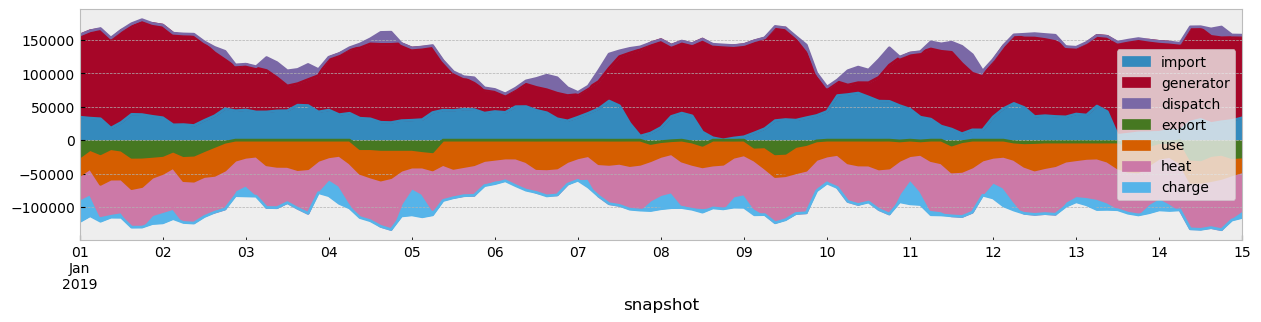

In [35]:
import myUtils as utils

import importlib
importlib.reload(utils)

df = pd.DataFrame(index = n.snapshots)


importLinkIds = utils.de_import_elec_grouper(n, 'Link').tolist()
importLinIds = utils.de_import_elec_grouper(n, 'Line').tolist()
importLineRIDS = utils.de_import_elec_reverse_grouper(n, 'Line').tolist()

df['import'] = - n.links_t.p1[importLinkIds].sum(axis=1) \
  - n.lines_t.p1[importLinIds].clip(upper=0).sum(axis=1) \
  - n.lines_t.p0[importLineRIDS].clip(upper=0).sum(axis=1)



generatorGeneratorIds =  utils.de_generator_grouper(n, 'Generator').tolist()
generatorLinkIds =  utils.de_generator_grouper(n, 'Link').tolist()
df['generator'] =  n.generators_t.p[generatorGeneratorIds].sum(axis=1) \
  + n.links_t.p1[generatorLinkIds].sum(axis=1)

storeStorageIds = utils.de_elec_store_grouper(n, 'StorageUnit').tolist()
storeStoreIds = utils.de_elec_store_grouper(n, 'Store').tolist()
df['dispatch'] = n.storage_units_t.p_dispatch[storeStorageIds].sum(axis=1) \
  + n.stores_t.p[storeStoreIds].clip(lower=0).sum(axis=1)


# use
exportLinkIds = utils.de_export_elec_grouper(n, 'Link').tolist()
exportLinIds = utils.de_export_elec_grouper(n, 'Line').tolist()
df['export'] = - n.links_t.p0[exportLinkIds].sum(axis=1) \
  - n.lines_t.p0[exportLinIds].clip(lower=0).sum(axis=1) \
  - n.lines_t.p1[importLineRIDS].clip(upper=0).sum(axis=1)


useLinkIds = utils.de_elec_use_grouper(n, 'Link').tolist()
useLoadIds = utils.de_elec_use_grouper(n, 'Load').tolist()
df['use'] = - n.loads_t.p[useLoadIds].sum(axis=1)
df['heat'] =  -n.links_t.p0[useLinkIds].clip(lower=0).sum(axis=1)

storeStorageIds = utils.de_elec_store_grouper(n, 'StorageUnit').tolist()
storeStoreIds = utils.de_elec_store_grouper(n, 'Store').tolist()
df['charge'] = - n.storage_units_t.p_store[storeStorageIds].sum(axis=1)\
  + n.stores_t.p[storeStoreIds].clip(upper=0).sum(axis=1)


total_use = (df['export'] + df['use'] + df['charge'] + df['heat'])
total_produce= (df['import'] + df['generator'] + df['dispatch'])


df['2019-01-01 00:00:00': '2019-1-15 00:00:00'].plot(kind='area', figsize=(15,3))


NameError: name 'importLineRIDS' is not defined